<a href="https://colab.research.google.com/github/jordanbuddenhagen/Project-2/blob/main/Project_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}
from warnings import filterwarnings

# First Choice

In [2]:
filename = '/content/healthcare-dataset-stroke-data[1].csv' 

df_stroke = pd.read_csv(filename)
df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
pd.set_option('display.max_rows', None)

In [4]:
df_stroke.drop(columns= [ 'work_type', 'id', 'ever_married'], inplace=True, axis=1)

### Dropping these two columns-- not needed with what I am trying to find.  id- just a person id number.  With childern in the study, I am going to get rid of Marriage and work type.  Both could be skewed in data set.  

In [5]:
df_stroke.duplicated().sum()

0

### There is no duplicates.

In [6]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   Residence_type     5110 non-null   object 
 5   avg_glucose_level  5110 non-null   float64
 6   bmi                4909 non-null   float64
 7   smoking_status     5110 non-null   object 
 8   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 359.4+ KB


In [7]:
df_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

#### BMI we will average out the numbers.  

In [8]:
#df_stroke[df_stroke['bmi'].isna()] 
#Exploring the data of missing BMis

In [9]:
df_stroke.fillna(df_stroke['bmi'].mean(), inplace=True)

In [10]:
df_stroke.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
df_stroke['bmi'].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [12]:
df_stroke.shape

(5110, 9)

In [13]:
df_stroke.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
Residence_type          2
avg_glucose_level    3979
bmi                   419
smoking_status          4
stroke                  2
dtype: int64

In [14]:
dtypes = df_stroke.dtypes 
str_columns = dtypes[dtypes=='object'].index 
str_columns 

Index(['gender', 'Residence_type', 'smoking_status'], dtype='object')

In [15]:
for col in str_columns: 
  print(f'- Column= {col}') 
  print(df_stroke[col].value_counts(dropna=False))

- Column= gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
- Column= Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
- Column= smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


- Most values look pretty good.  I am going to drop the row with the 'Other' gender.  While there may be that possiblity, it is only one value and is very imbalanced.  

In [16]:
df_stroke_gendother = df_stroke.loc[df_stroke['gender'] == 'Other']  #Finding other value

In [17]:
df_stroke_gendother.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,Rural,143.33,22.4,formerly smoked,0


In [18]:
df_stroke.drop(axis=0, index=3116, inplace=True)

In [19]:
for col in str_columns: 
  print(f'- Column= {col}') 
  print(df_stroke[col].value_counts(dropna=False))

- Column= gender
Female    2994
Male      2115
Name: gender, dtype: int64
- Column= Residence_type
Urban    2596
Rural    2513
Name: Residence_type, dtype: int64
- Column= smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64


In [20]:
df_stroke.shape

(5109, 9)

### 'Other' row is dropped

In [21]:
df_stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894508,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Looking at the data-- there is an outlier in age and bmi  

## There is always a chance at any age a child or adult could have a stroke.  I am going to keep all data in for age.

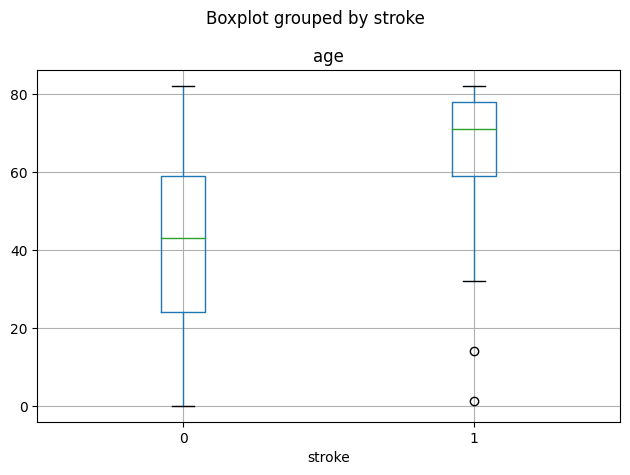

In [22]:
df_stroke.boxplot(column = 'age', by ='stroke') 
plt.tight_layout()

In [23]:
#df_strokeage = df_stroke['age'].sort_values(ascending=True)
#df_strokeage.head(200)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

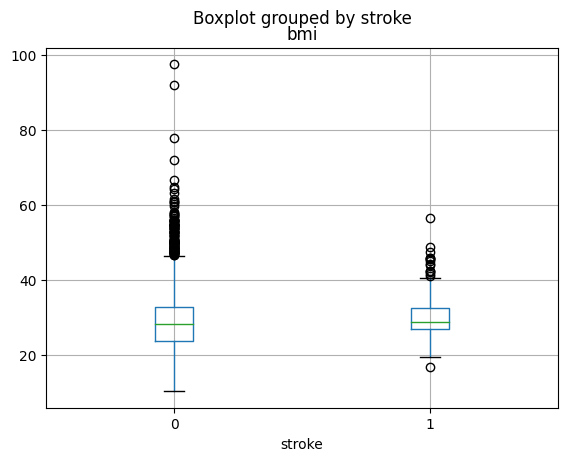

In [24]:
df_stroke.boxplot(column='bmi', by='stroke') 
plt.tight_layout

In [25]:
df_strokebmi = df_stroke['bmi'].sort_values(ascending=False)
df_strokebmi.head(30)

2128    97.6
4209    92.0
928     78.0
544     71.9
1559    66.8
358     64.8
4188    64.4
2764    63.3
3825    61.6
2840    61.2
270     60.9
4838    60.9
466     60.2
3588    59.7
3060    58.1
4351    57.9
1898    57.7
715     57.5
1595    57.3
4475    57.2
4154    57.2
4952    56.6
113     56.6
2081    56.1
1660    56.0
4225    55.9
1584    55.9
662     55.7
2555    55.7
672     55.7
Name: bmi, dtype: float64

# I am going to delete row 2128, 4209, 928 and 544 
- Even 71.9 BMI is 5'10" 500 lbs.  It is possible, but those are extreme cases.  

In [26]:
df_stroke.drop(axis=0, index= [2128, 4209, 928, 544], inplace=True)


In [27]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5105 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5105 non-null   object 
 1   age                5105 non-null   float64
 2   hypertension       5105 non-null   int64  
 3   heart_disease      5105 non-null   int64  
 4   Residence_type     5105 non-null   object 
 5   avg_glucose_level  5105 non-null   float64
 6   bmi                5105 non-null   float64
 7   smoking_status     5105 non-null   object 
 8   stroke             5105 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 398.8+ KB


## Quick plot of Strokes and hypertenstion

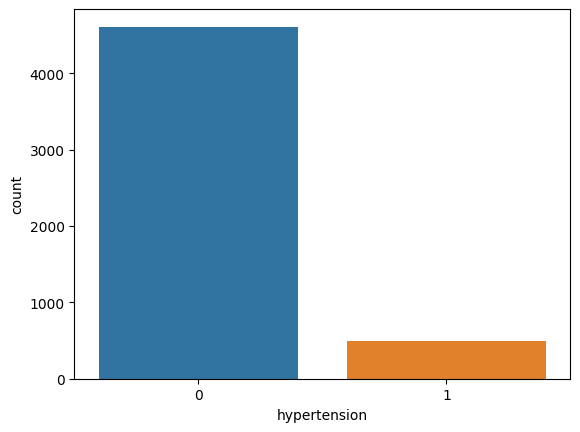

In [28]:
graph_hyper = sns.countplot(data = df_stroke, x='hypertension')

# Heat Map

<ipython-input-29-a24b4de6bb33>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_stroke.corr()


<Axes: >

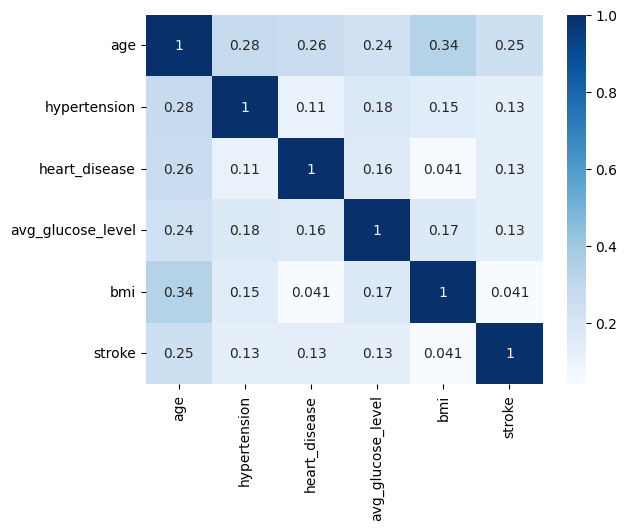

In [29]:
df_corr = df_stroke.corr()
sns.heatmap(data=df_corr, cmap='Blues', annot= True)

# Age and BMI is my highest corrleated data between each other for correlated numeric data, and that is still cosidered a low correlation.  I will have to explore data more to find trends. 

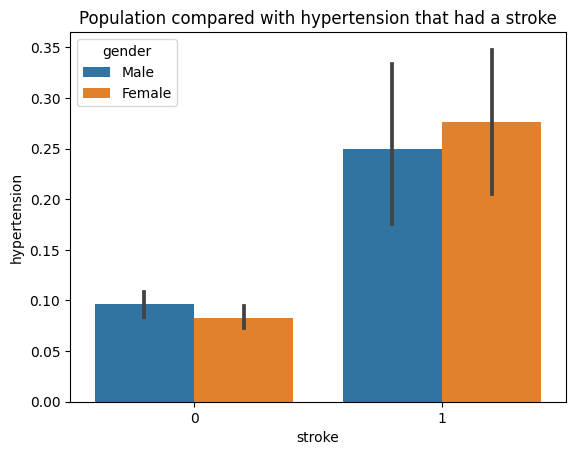

In [30]:
graph_hyperandstrokes = sns.barplot(data=df_stroke, x='stroke', y='hypertension', hue='gender')
graph_hyperandstrokes.set_title('Population compared with hypertension that had a stroke');

- Patients with lower hypertension had fewer strokes. 
- Males and Females were more likely to have a stroke with higher hypertension.

<ipython-input-31-c0d268983fb3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_stroke[df_stroke['stroke'] == 0]['age'], hist=False, color="blue").set(title='Average Age of people with Strokes')
<ipython-input-31-c0d268983fb3>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

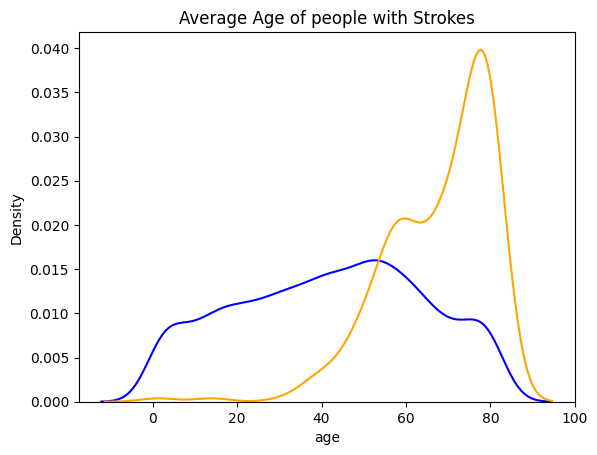

In [31]:
sns.distplot(df_stroke[df_stroke['stroke'] == 0]['age'], hist=False, color="blue").set(title='Average Age of people with Strokes')
sns.distplot(df_stroke[df_stroke['stroke'] == 1]['age'], hist=False, color="orange");

plt.show();

## As expected- Age plays a huge factor in who has a stroke.

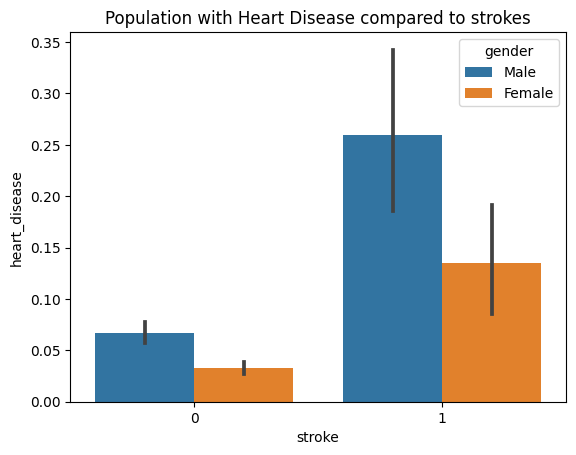

In [32]:
graph_hdandstrokes = sns.barplot(data=df_stroke,x='stroke', y='heart_disease', hue='gender' )
graph_hdandstrokes.set_title('Population with Heart Disease compared to strokes');

## Heart disease was more prevelant in males that had a stroke compared to females. Heart disease is another factor in people that have had a stroke.

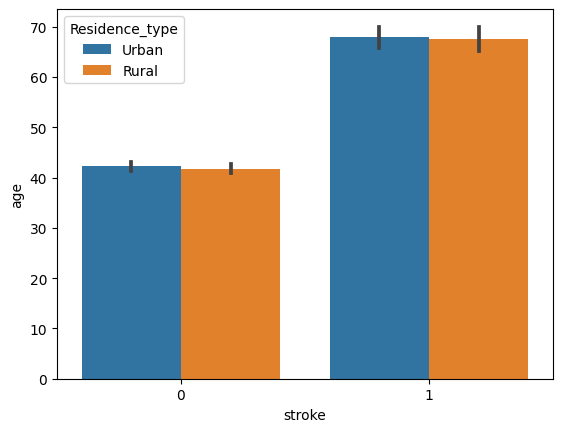

In [33]:
graph_strokes_area = sns.barplot(data=df_stroke, x='stroke', y='age', hue='Residence_type')

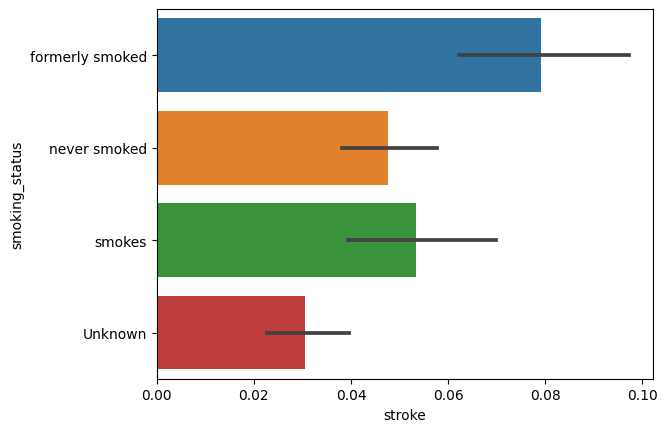

In [34]:
graph_strokes= sns.barplot(data=df_stroke, x='stroke', y='smoking_status')

## Smokers have a higher chance at having a stroke, but it is not a significant amount.  

## In the data, most important factors are heart disease, hypertension and age.  

1. Source of data
- https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download  StrokePrediction Dataset
2. Brief description of data
- It is used to predict whether a patient is likely to get a stroke based on specific parameteres.  
3. What is the target?
- In the end I think it will be if this person has had a stroke before and possibly be affected by living.
4. What does one row represent? (A person?  A business?  An event? A product?)
 - hypertension- high blood pressure
5. Is this a classification or regression problem?
- classification
6. How many features does the data have?
- 12 features
7. How many rows are in the dataset?
- 5110 rows
8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?  

- Alot of features could be manipulted in this data set.  I think creating unique columns, making sure I check value counts before I get going.  Also, make sure data types are correct. 